<a href="https://colab.research.google.com/github/hpan270/MSA/blob/master/keras_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [55]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 128
num_classes = 10
epochs = 100
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [56]:
json_str=model.to_json()
open("keras_cifar10_e100.json",'w').write(json_str)

4992

In [0]:
from keras import callbacks

In [0]:
csvlogger=callbacks.CSVLogger('keras_cifar10_csvlogger_e100.csv',separator=',',append=False)
chkpt=callbacks.ModelCheckpoint('keras_cifar10_chkpt_e100.hdf5',verbose=1, save_best_only=True)

In [59]:
print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[csvlogger,chkpt],
          shuffle=True)

Not using data augmentation.
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 130us/step - loss: 2.0273 - acc: 0.2483 - val_loss: 1.8214 - val_acc: 0.3467

Epoch 00001: val_loss improved from inf to 1.82139, saving model to keras_cifar10_chkpt_e100.hdf5
Epoch 2/100
40000/40000 [==============================] - 5s 114us/step - loss: 1.7377 - acc: 0.3671 - val_loss: 1.6283 - val_acc: 0.4193

Epoch 00002: val_loss improved from 1.82139 to 1.62826, saving model to keras_cifar10_chkpt_e100.hdf5
Epoch 3/100
40000/40000 [==============================] - 5s 115us/step - loss: 1.6265 - acc: 0.4033 - val_loss: 1.6349 - val_acc: 0.4133

Epoch 00003: val_loss did not improve from 1.62826
Epoch 4/100
40000/40000 [==============================] - 5s 115us/step - loss: 1.5413 - acc: 0.4408 - val_loss: 1.4767 - val_acc: 0.4672

Epoch 00004: val_loss improved from 1.62826 to 1.47668, saving model to keras_cifar10_chkpt_e100.hdf5
Epoch 5/

In [60]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 74us/step
Test loss: 0.6680414448738098
Test accuracy: 0.7838


In [61]:
!ls -lht

total 9.7M
-rw-r--r-- 1 root root 5.6K Aug  6 04:17 keras_cifar10_csvlogger_e100.csv
-rw-r--r-- 1 root root 9.6M Aug  6 04:17 keras_cifar10_chkpt_e100.hdf5
-rw-r--r-- 1 root root 4.9K Aug  6 04:09 keras_cifar10_e100.json
drwxr-xr-x 1 root root 4.0K Aug  2 16:06 sample_data


In [0]:
# from google.colab import files

# files.download('keras_cifar10_chkpt_e100.hdf5')
# files.download('keras_cifar10_e100.json')
# files.download('keras_cifar10_csvlogger_e100.csv')

In [64]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import model_from_json

themodel=model_from_json(open('keras_cifar10_e100.json').read())  
themodel.load_weights('keras_cifar10_chkpt_e100.hdf5')
themodel.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

themodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

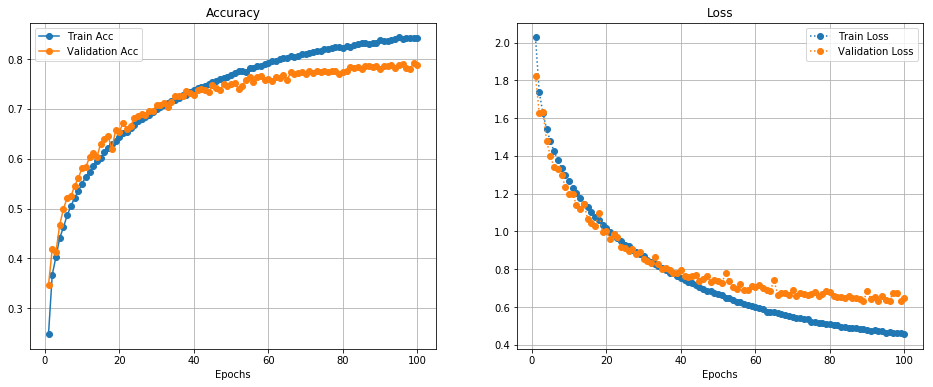

In [65]:
#plot the train/validation acc/loss in plot
import pandas as pd
import matplotlib.pyplot as plt
train_rslt=pd.read_csv('keras_cifar10_csvlogger_e100.csv',sep=',')
train_rslt.epoch=train_rslt.epoch+1
f=plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
plt.plot(train_rslt['epoch'], train_rslt['acc'],'-o', label='Train Acc')
plt.plot(train_rslt['epoch'], train_rslt['val_acc'],'-o',label='Validation Acc')  
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.grid()
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(train_rslt['epoch'], train_rslt['loss'],':o', label='Train Loss')
plt.plot(train_rslt['epoch'], train_rslt['val_loss'],':o',label='Validation Loss')  
plt.title("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.legend(loc='best')


In [66]:
import numpy as np
labels_test=[x.argmax() for x in y_test[::1,:]]
type(labels_test)
print(labels_test[:5])

ypred=themodel.predict(x_test)
pred_labels=[x.argmax() for x in ypred[::1,:]]
pred_labels[:5]

[3, 8, 8, 0, 6]


[3, 8, 8, 0, 6]

In [67]:
#metrics report
from sklearn.metrics import classification_report
crpt=classification_report(labels_test,pred_labels)
print(crpt)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.89      0.91      0.90      1000
           2       0.67      0.71      0.69      1000
           3       0.62      0.60      0.61      1000
           4       0.75      0.74      0.75      1000
           5       0.74      0.66      0.70      1000
           6       0.79      0.88      0.83      1000
           7       0.86      0.81      0.84      1000
           8       0.86      0.87      0.86      1000
           9       0.85      0.87      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



0.7846


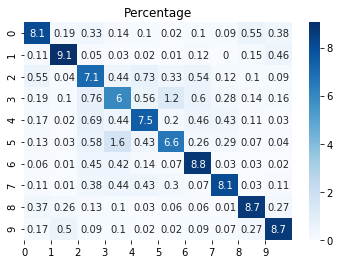

In [68]:
#confusion matrix and heatmap plot and matshow plot
from sklearn.metrics import confusion_matrix
import seaborn as sn
mx=confusion_matrix(labels_test, pred_labels)
print((np.array(pred_labels)==np.array(labels_test)).mean())
f=plt.figure()
sn.heatmap(mx/100, annot=True, cmap=plt.cm.Blues) #plot percent, total 10k test labels
plt.xticks(ticks=range(10))
plt.title('Percentage')
plt.show()